In [366]:
#ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from IPython.display import set_matplotlib_formats
%matplotlib inline

In [378]:
#ignore

set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 18})

## Introduction 

During the training steps, machine learning models learn how the _features_ (or inputs) are correlated with the _target_ variable you are trying to predict. If you are just trying to make predictions, without driving the inputs, then the difference between correlation and causation isn't important.

As argued in a [previous article](/goodharts-law.html), often one of the goals (if not __the__ goal) of a data science project is to identify what features our prediction is sensitive to, and inform how we should change our business practices. This approach only works if our correlations are causal. As a simple example, when looking at ice-cream sales, we might find

1. _Temperature is positively correlated with ice-cream sales in a city_
2. _The number of cars is positively correlated with ice-cream sales in a city_

The first relationship is (likely) causal; more people seek out cold foods on hot days. Our business cannot do much to control the temperature, so this insight isn''t that useful. The second relationship is not causal; the number of cars is positively correlated with the population of the city, as is the amount of ice-cream consumed. Introducing more people would increase the number of cars and amount of ice-cream consumed, but just bringing more cars into the city would not have the desired effect of boosting ice-cream sales. 

This article looks at a relatively common occurance of _pathological demand_, where when we find a positive correlation between price and number of sales. For example, hotel rooms have wildly varying demand, and hotels change their prices according to what they forecast demand to be. If we looked at _price of room_ against _bookings_, we would see more rooms getting booked as the price increased. The bookings don't _because_ the prices go up, we are seeing this relationship because we demand for the rooms is highest when the prices are highest.

We don't want to compare the high number of bookings for a &#36;300/night room on labor day weekend, to the low number of books at \$80/night room in the first weekend of February, and use that to conclude we should raise prices. What we want to do is estimate how many bookings we _would_ have made if we increased the price from &#36;300/night on labor day weekend (with a similar analysis for our &#36;80/night price for the first weekend of February).

This is an example of [Simpson's paradox](/Simpsons-paradox), where we see a (pathological) postitive correlation between price and bookings if we ignore demand, but a (expected) negative correlation if we control for demand.  We'll look at two different examples of how to estimate the effect of changing the price:
* _Ridesharing apps_: where we can measure demand, and control for it (this article)
* _Flight bookings_: using instrumental variables (next article in series)



# Ridesharing

Let's simulate some ridesharing data. For the moment, we will eliminate (important!) variables such as distance traveled. We will control our app through surge pricing, by charging a lot when lots of people are demanding rides, which we can use to encourage more drivers out.

* There is an external demand, which is in dollars, which measures the amount a typical customer is willing to pay for a ride.
* When demand is high, more users open the app to check the price of the ride.
* After seeing the price, the customer decides whether or not to take the ride.

When the demand is &#36;10, we know that there are fewer people opening the app, and that there are fewer people requesting rides, than when the demand is &#36;20. We will write a function for whether or not the customer accepts the ride.

In [368]:
def does_accept_ride(demand, price_shown):
    auto_accept = demand
    threshold = np.exp(-(price_shown - auto_accept)/(0.8*demand))
    return np.random.rand() < threshold

We can see that if the price is less than the demand, the customer accepts. As the price goes above demand, the probability of accepting drops off exponentially:

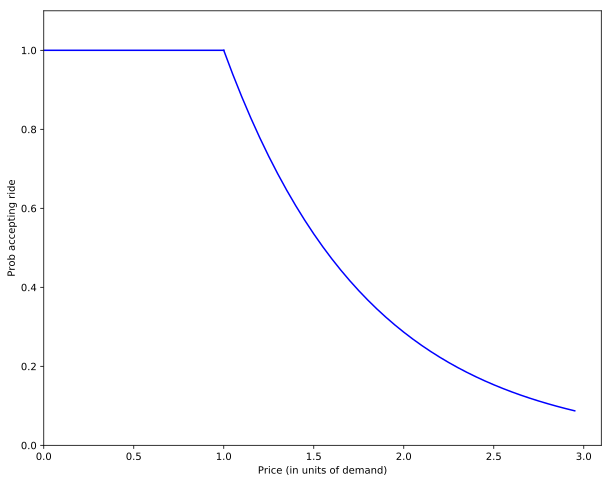

In [369]:
#ignore
frac_prices = np.arange(1, 3, 0.05)
plt.plot([0,1], [1,1], 'b-')
plt.plot(frac_prices, np.exp(-(frac_prices-1)/0.8), 'b-')
plt.ylim(0,1.1)
plt.xlim(0, None)
plt.xlabel('Price (in units of demand)')
plt.ylabel('Prob accepting ride');

The piece that is directly under the ridesharing companies control is how much they choose to charge for a given ride. The company charges more as demand increases, and there is some noise as well.

In [370]:
MIN_PRICE = 5

def simulate_single_customer(day, demand):
    price_shown = max(MIN_PRICE, MIN_PRICE + 0.95*demand + 0.1*demand*np.random.normal())
    is_accepted = does_accept_ride(demand, price_shown)
    return {'day': day, 'demand': demand, 'price_shown': price_shown, 
            'is_accepted': is_accepted, 'payment': is_accepted * price_shown}

We can then generate some demand data, and some client requests. In this simple model, we make more customers make requests when demand is higher.

In [371]:
np.random.seed(42)

# demand on each of the 365 days, in terms of average amount a 
# customer is willing to pay
external_demand = stats.gamma(loc=0, a=5, scale=5).rvs(365)

simulated_data = []

for day, demand in enumerate(external_demand):
    num_decide_to_go = stats.poisson(mu=10*demand).rvs(1)[0]
    for _ in range(num_decide_to_go):
        simulated_data.append(simulate_single_customer(day, demand))

simulated_df = pd.DataFrame(simulated_data)  

Let's see what the external demand looks like:

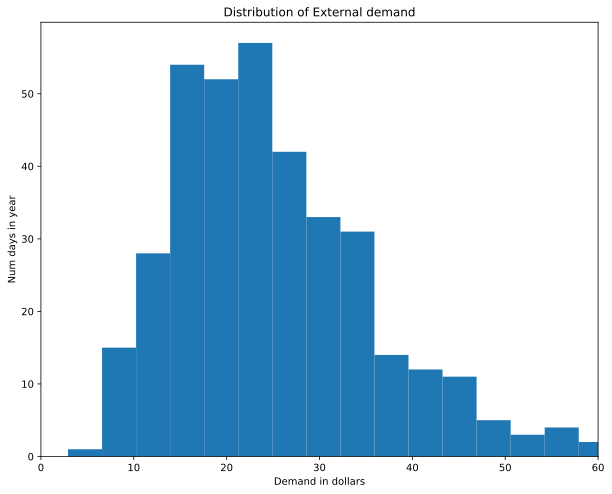

In [372]:
#ignore
plt.title('Distribution of External demand')
plt.xlim(0, 60)
plt.xlabel('Demand in dollars')
plt.ylabel('Num days in year')
plt.hist(external_demand, bins=25);

#### How do number of rides change with price?

We can see a very strong relationship: as the price increases, so do the number of rides. This is because we see more customers when demand is high _and_ that people are willing to pay more when demand is high. 

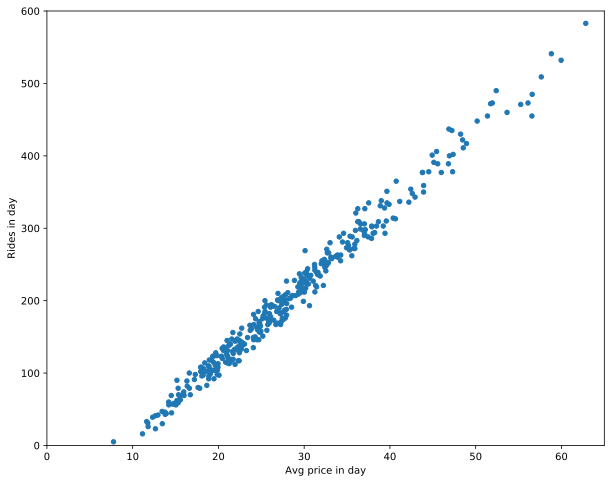

In [373]:
#ignore
(simulated_df[simulated_df.is_accepted]
    .groupby('day')
    .agg({'price_shown': 'mean', 'payment': 'sum', 'is_accepted': 'count'})
    .plot.scatter('price_shown', 'is_accepted'))
plt.xlim(0, 65)
plt.ylim(0, 600)
plt.ylabel('Rides in day')
plt.xlabel('Avg price in day');

It makes sense if more people are looking for rides when demand is high that we see more rides on those days. 


#### Cancellations vs price?

What about the people that cancelled their rides? Perhaps we can see higher cancellation rates we sa price goes up? Even in this case, we see that as price goes up, the percentage of rides goes up.

In [374]:
#ignore
simulated_df['price_bin'] = pd.cut(simulated_df['price_shown'], bins=np.arange(5, 60, 5))

(simulated_df.groupby('price_bin')
 .is_accepted.mean()
 .to_frame()
 .reset_index()
 .rename(columns={'is_accepted':'% rides accepted', 'price_bin':'price_range'})
 .style
 .format({'% rides accepted': '{:.2%}'})
)

,price_range,% rides accepted
0,"(5, 10]",15.62%
1,"(10, 15]",58.65%
2,"(15, 20]",73.26%
3,"(20, 25]",78.74%
4,"(25, 30]",83.02%
5,"(30, 35]",85.27%
6,"(35, 40]",86.39%
7,"(40, 45]",87.46%
8,"(45, 50]",89.18%
9,"(50, 55]",89.19%


### Accounting for demand

The reason we are seeing this weird behavior is that demand affects both demand and price. If we look at grouping days with a specific number of demand (or, if that cannot be measured directly, the number of clients coming in on a single day) then we aren't running into the problem where we are comparing people's willingness to pay on a busy Friday when a concert is in town to a sleepy Tuesday. Instead, we are comparing prices on days that are like each other.

Let's bin the demand in units of $5, and compare what happens to the fraction of rides accepted at that demand and price point. We leave cells blank where we don't have any data.

In [375]:
#ignore
simulated_df['demand_bin'] = pd.cut(simulated_df['demand'], bins=np.arange(0, 50, 5))
(
    simulated_df.pivot_table(index='price_bin', columns='demand_bin', aggfunc='mean', values=['is_accepted'])
 .style.format(lambda x: '' if np.isnan(x) else f'{x:.2%}')
)

We see, _at a given level of demand_, increasing the price leads to a decrease in the number of accepted rides.

What we really want to do is compare what actually happened to what _would have happened_ if we had set the prices differently. This is different from seeing the days where we set the prices high and comparing them to days where we set the prices low (we don't want to compare Tuesdays and Fridays!)

#### How applicable is this to real ridesharing?

For real ridesharing apps, the prices are being set in real time in response to customer demand. If we need more drivers to cope with existing demand, we might need to bump prices up a little bit. Not enough riders? Try decreasing the prices. Because this is being done in real time, we are implicitly comparing "like-demands", as demand changes somewhat slowly. 

This type of analysis would be much more important if, as a company, we were trying to predict what would happen if we paid drivers more, or were launching different coupons for customers. 


There are some other issues to consider when designing pricing experiments in real ridesharing apps, such as interference, where exposure of a treatment to one subject can affect people not exposed to the treatment. A really nice example is discussed in [Lyft's pricing experiment](https://eng.lyft.com/experimentation-in-a-ridesharing-marketplace-b39db027a66e) blog post.


#### A Counterfactual

We also had the complete method for generating the data to hand as well. A couple of interesting things to do with the analysis is to

* increase prices by some amount (e.g. 10%) and see what happens to the number of rides metric.
* shuffle the prices shown, so the prices have the same overall distribution, and see what would happen the number of rides metric.

This gives a better idea of what would happen. I'll do the second one (shuffling) to show how it works, but didn't include it above, as if we know the underlying data generation process we don't actually need to do analysis of data -- the model gives us a precise prediction of what would happen. When performing an analysis, you generally don't have access to the geneartion process!

What does it mean to shuffle data? We are going to pretend we used the exact same set of prices, but instead of showing them to the customers we did (where we showed higher prices when demand was high), we are going to show them the prices randomly. We then need to calculate whether or not the customer would have accepted the ride at this new price. This is why we need a good model: because the customer _didn't_ actually see this price, we cannot look at the data to see what they did; instead we need to use our model to see what they _would have done_ if we offered them this price instead.

This dataset, called the _counterfactual_, has the price now no longer related to demand, and when we look at price vs number of bookings, we will see a negative correlation. Now to see it in code:

In [376]:
counterfactual_df = simulated_df.copy()

# shuffle prices
counterfactual_df['price_shown'] = np.random.permutation(counterfactual_df['price_shown'])
# do they accept the ride at this demand, and this price?
counterfactual_df['is_accepted'] = (counterfactual_df
                                    .apply(lambda row: does_accept_ride(row.demand, row.price_shown),
                                          axis=1)
                                   )
counterfactual_df['payment'] = counterfactual_df['is_accepted'] * counterfactual_df['price_shown']

Without doing any bucketing, we can look at the correlation coefficient between price and fraction of accepted trips of $-0.41$. By bucketing by price shown, we see a strong and clear decrease of number of accepted trips as price increases.

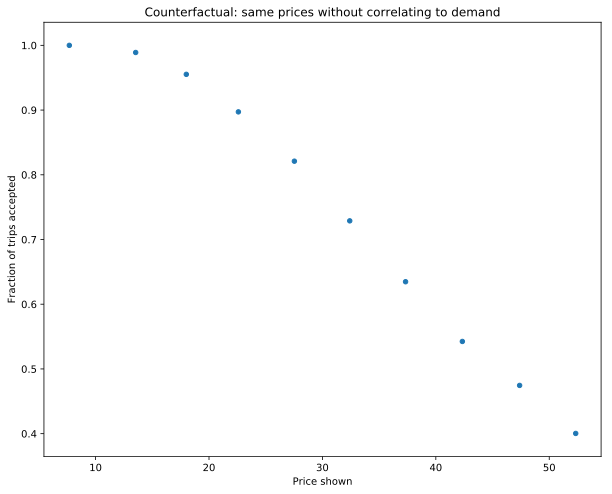

In [377]:
#ignore
counterfactual_df['price_bin'] = pd.cut(counterfactual_df.price_shown, bins=np.arange(0, 60, 5))

(counterfactual_df
 .groupby('price_bin')
 .agg({'price_shown': 'mean', 'is_accepted': 'mean'})
 .plot
 .scatter('price_shown', 'is_accepted')
)

plt.xlabel('Price shown')
plt.ylabel('Fraction of trips accepted')
plt.title('Counterfactual: same prices without correlating to demand');

It is important that in this example, we generated the data and therefore had access to the _exact_ model that was used (i.e. we knew how the customer would respond in changes to price). If we were doing this analysis on real data, we wouldn't have this technique available unless we had estimated a causal model. 

_This model is shown to illustrate that it is the correelation of the prices and demand that causes the issue, rather than a suggestion for how you would do this analysis yourself with purely observational data._

#### Visualizing causal relationships

When making arguments about what are causal relations (i.e. changing X should change Y), and what are just correlations, it is often valuable to visualize the flow of information. We draw a node for each variable, and an arrow from `X` to `Y` if we think that changing $X$ directly leads to a change in Y. These visualizations are a type of graph, specifically a _directed acyclic graph_ (DAG).

In [394]:
#ignore
from graphviz import Digraph
# Create Digraph object
dot = Digraph()
# Add nodes 1 and 2
dot.node('Demand')
dot.node('Price Shown')
dot.node('Prob accept')
dot.node('Num app views')
dot.node('Num rides')

# Add edge between 1 and 2
dot.edge('Demand', 'Price Shown')
dot.edge('Demand', 'Num app views')
dot.edge('Demand', 'Prob accept')
dot.edge('Price Shown', 'Prob accept')
dot.edge('Num app views', 'Num rides')
dot.edge('Prob accept', 'Num rides')
dot.save('../images/pathological_demand/rideshare_dag.png');

![DAG for our simplified rideshare company](/images/pathological_demand/rideshare_dag.png)

If we are looking at the number of rides taken, we see that demand changes the number of people that will open teh app, the price that the ridesharing company will show, and the probability that someone will accept the ride _alongside the price_. This helps someone realize if they want to know what the effect of changing the price is, we should do so in a way that keeps the demand constant.

The rules about what to keep constant, and what to allow to vary, are the subject of _causal analysis_. In a nutshell, causal analysis is supposed to help us distinguish between information that is due to correlation, and find which relationships are truely causal.

## Summary

* Soft classification gives scores, where a higher score for that class means the model is more confident in its prediction.
* For binary classification, you only need one score (generally the score of the positive class).
* A probability can be used as a score (even in the multiclass case).
* Many Scikit-learn models, such as Tree-based methods, ensemble methods, kNN, and Naive Bayes have a `predict_proba` method; but these should really be thought of as giving scores rather than "true" probabilities.
* A calibration curve is a good way to check if your probabilities are accurate.
* Platt Scaling is a way of trying to recalibrate your model's probabilities to be probabilities (rather than scores), but you should check calibration after fitting.

The `predict_proba` is a bad name, but as Phil Karlton (a designer for Netscape) once told us:
>There are only two hard things in Computer Science: cache invalidation and naming things.
>
>-- Phil Karlton

### Acknowledgements
Thanks to Vivien Tsao and Joyce Lee for participating in discussion about this problem, after reviewing the flight example in Business Data Science. 

### Resources

* ["Business Data Science"](https://www.amazon.com/Business-Data-Science-Combining-Accelerate-ebook/dp/B07HRVYTHV) (M. Taddy), chapter 5 on experimentation introduces the idea of pathological demand, and has a good treatment of instrumental variables. Flight example inspired by this chapter.
* [Causal Estimation lectuers](https://www.stat.cmu.edu/~cshalizi/402/lectures/23-causal-estimation/lecture-23.pdf) for CMU's Advanced Analytics class has a section introducing instrumental variables
* ["Instrumental Variables and the Search for Identification: From Supply and Demand to Natural Experiments"](https://economics.mit.edu/files/18) is a introductory review of the instrumental variable technique.
* ["An empirical analysis of delays in the Turkish Airlines network"](https://www.researchgate.net/publication/320157728_An_empirical_analysis_of_delays_in_the_Turkish_Airlines_network#pf5) for an actual study using (different) instrumental variables but real data on a flight problem.
* ["Simpson's Paradox"](/simpsons-rule.html)